In [1]:
%reset
# import get_marked2pt as m2pt
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import dill
import sys, os
from astropy.io import fits
import scipy.interpolate as interpolate
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'
font = {'size': 18}
matplotlib.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import pickle as pk



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure_zhres.pk'
out_dict = dill.load(open(savefname, 'rb'))




In [3]:
import scipy.special as ss

def f_cen(logmhalo,logmmin,siglogm,fmaxcen):
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = fmaxcen * ncen
    return np.log10(ncen + 1e-80)

def f_cen_exp(logmhalo,logmmin,siglogm,logmstar,n):
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = ncen * (np.exp(1.*((logmhalo)/logmstar)**n))    
#     ncen  = ncen * ((1.*((logmhalo)/logmstar)**n))    
#     ncen  = ncen * ((10**logmhalo/10**logmstar)**n)
    return np.log10(ncen + 1e-80)

def f_sat(logmhalo,logmmin,siglogm,fmaxcen,logm1,alpha): 
    fcen = 10**f_cen(logmhalo,logmmin,siglogm,fmaxcen)
    nsat  = fcen * (10**logmhalo/10**logm1)**alpha
    return np.log10(nsat + 1e-80)

# def f_sat(logmhalo,logmmin,siglogm,logmstar,n,logm1,alpha): 
#     fcen = 10**f_cen_exp(logmhalo,logmmin,siglogm,logmstar,n)
#     nsat  = fcen * (10**logmhalo/10**logm1)**alpha
#     return np.log10(nsat + 1e-80)

def f_sat_yx(logmhalo,logmmin,siglogm,fmaxcen,logm1,alpha,db=False): 
    nsat  = (10**logmhalo/10**logm1)**alpha
    return np.log10(nsat)

def chi2_all(logmmin,siglogm,fmaxcen,logm1,alpha):
    return np.sum((f_cen(x_cen,logmmin,siglogm,fmaxcen)-y_cen)**2)+np.sum((f_sat(x_sat,logmmin,siglogm,fmaxcen,logm1,alpha)-y_sat)**2)

def get_Nc_Ns_theory(logmhalo,params):
    ncen = 10**(f_cen(logmhalo,params[0],params[1],params[2]))
    nsat = 10**(f_sat(logmhalo,params[0],params[1],params[2],params[3],params[4]))
#     ncen = 10**(f_cen_exp(logmhalo,params[0],params[1],params[2],params[3]))
#     nsat = 10**(f_sat(logmhalo,params[0],params[1],params[2],params[3],params[4],params[5]))

    return np.hstack([ncen, nsat])



    


In [26]:
def get_is_within_prior(bias_param, bias_prior):
    if len(bias_prior) == 2 * len(bias_param):
        is_not_within_prior = 0
        for pj in range(len(bias_param)):
            param = bias_param[pj]
            param_prior_min, param_prior_max = bias_prior[2 * pj], bias_prior[2 * pj + 1]
            if (param > param_prior_min) & (param < param_prior_max):
                is_not_within_prior += 0
            else:
                is_not_within_prior += 1

        if is_not_within_prior == 0:
            is_within_prior = True
        else:
            is_within_prior = False

    else:
        print('Put correct priors on all the parameters of chain')
        sys.exit(1)

    return is_within_prior



In [27]:
def lnprob_func(bias_param, bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp):
    is_within_prior = get_is_within_prior(bias_param, bias_prior)
    if is_within_prior:
        Pk_theory_comp = get_Nc_Ns_theory(logmhalo,bias_param)
        valf = -0.5 * np.dot(np.dot(np.transpose((Pk_obs_comp - Pk_theory_comp)), incov_obs_comp),
                             (Pk_obs_comp - Pk_theory_comp))
    else:
        valf = -np.inf

    return valf

def get_sampler(nwalkers,  bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp):
    import emcee
    ndim = len(bias_prior)/2
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_func,
                                    args=[bias_prior,logmhalo, Pk_obs_comp, incov_obs_comp])
    return sampler


def get_initial_state(nwalkers, bias_prior,state_type='random'):
    p0_array = []
    for bj in range(0, (len(bias_prior) - 1), 2):
        rand_for_bj = np.random.rand(nwalkers)
        bj_new = bias_prior[bj] + rand_for_bj * (bias_prior[bj + 1] - bias_prior[bj])
        p0_array.append(bj_new)
    p0_array = np.vstack(p0_array)
    p0_final = p0_array.T
    return p0_final

def get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='most_like'):
    if filename is not None:
        f = open(filename, "w")
        f.close()

    sampler.run_mcmc(p0, nsteps, progress=True)
    logprob = sampler.get_log_prob(flat=True)
    para_mcmc_chain = sampler.flatchain
    ind_min = np.argmin(-1.*logprob)
    
    para_avg_mcmc = (np.sum(para_mcmc_chain, axis=0)) / (len(para_mcmc_chain))
    para_median_mcmc = np.median(para_mcmc_chain, axis=0)

    final_pos_sigma = np.std(para_mcmc_chain, axis=0)

    if pos_type == 'most_like':
        final_pos = para_mcmc_chain[ind_min,:]
        most_like_pos = para_mcmc_chain[ind_min,:]
    elif pos_type == 'avg':
        final_pos = para_avg_mcmc
    elif pos_type == 'median':
        final_pos = para_median_mcmc
    else:
        print('No predefined pos_type given')
        sys.exit(1)

    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    print('Mean: ', para_avg_mcmc, ' Median: ', para_median_mcmc, ' Most-Like: ', most_like_pos, ' LogProb:', logprob[ind_min])

    return final_pos, final_pos_sigma, sampler





In [28]:
nwalkers = 40
nsteps = 4000
burn_steps = 2500

logmmin_p = [11.,14.]
siglogm_p = [0.1,0.8]
logmstar_p = [3.,5000.]
n_p = [0,3]
fmaxc_p = [0.1,0.8]
logm1_p = [11.,14.]
alpha_p = [0.5,2.]

param_prior = [logmmin_p[0],logmmin_p[1],siglogm_p[0],siglogm_p[1],fmaxc_p[0],fmaxc_p[1],logm1_p[0],logm1_p[1],alpha_p[0],alpha_p[1]]    
# param_prior = [logmmin_p[0],logmmin_p[1],siglogm_p[0],siglogm_p[1],logmstar_p[0],logmstar_p[1],n_p[0],n_p[1],logm1_p[0],logm1_p[1],alpha_p[0],alpha_p[1]]    




/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
  1%|          | 35/4000 [00:00<00:11, 349.30it/s]

0.6627551020408163


  1%|          | 35/4000 [00:00<00:11, 346.45it/s]

Mean acceptance fraction: 0.543
Mean:  [12.24613077  0.20256503  0.21750235 12.88676393  0.80202069]  Median:  [12.23761883  0.19867238  0.21433731 12.885131    0.80164234]  Most-Like:  [12.23742492  0.19856327  0.21431614 12.88479188  0.80167699]  LogProb: -6515.91491534455
0.7086734693877551


  1%|          | 32/4000 [00:00<00:12, 312.44it/s]

Mean acceptance fraction: 0.543
Mean:  [12.18333216  0.17942077  0.16935595 12.89727184  0.83068423]  Median:  [12.16816873  0.17274779  0.16498768 12.89511925  0.82811366]  Most-Like:  [12.16792385  0.17259981  0.16486661 12.8949149   0.82813715]  LogProb: -16489.454616750663
0.7545918367346939


  1%|          | 35/4000 [00:00<00:11, 344.71it/s]

Mean acceptance fraction: 0.543
Mean:  [12.37073807  0.38456902  0.212228   12.82435389  0.82889626]  Median:  [12.36686556  0.38376378  0.2109245  12.82221455  0.82586783]  Most-Like:  [12.36673319  0.38374999  0.21091023 12.82238983  0.82601452]  LogProb: -23106.536231850234
0.8005102040816326


  1%|          | 36/4000 [00:00<00:11, 354.37it/s]

Mean acceptance fraction: 0.545
Mean:  [12.13558881  0.26123855  0.19590769 12.72033454  0.79722412]  Median:  [12.12814771  0.25948901  0.19325993 12.71700152  0.79447979]  Most-Like:  [12.12808576  0.25948718  0.19322645 12.71711811  0.79455722]  LogProb: -31243.668900261677
0.8464285714285714


  1%|          | 35/4000 [00:00<00:11, 343.46it/s]

Mean acceptance fraction: 0.541
Mean:  [12.01316935  0.211776    0.16200942 12.54241275  0.84024852]  Median:  [11.99600008  0.20637036  0.1600449  12.54712166  0.84105092]  Most-Like:  [11.99588008  0.20632997  0.1600302  12.5470217   0.84109185]  LogProb: -27423.496390366545
0.8923469387755102


100%|██████████| 4000/4000 [00:13<00:00, 301.27it/s]


Mean acceptance fraction: 0.542
Mean:  [11.98080909  0.20055896  0.14118881 12.51263526  0.82802364]  Median:  [11.9605185   0.1960824   0.13720175 12.50236602  0.82584354]  Most-Like:  [11.96037702  0.19603226  0.1371263  12.5021523   0.82606118]  LogProb: -17364.037034776895


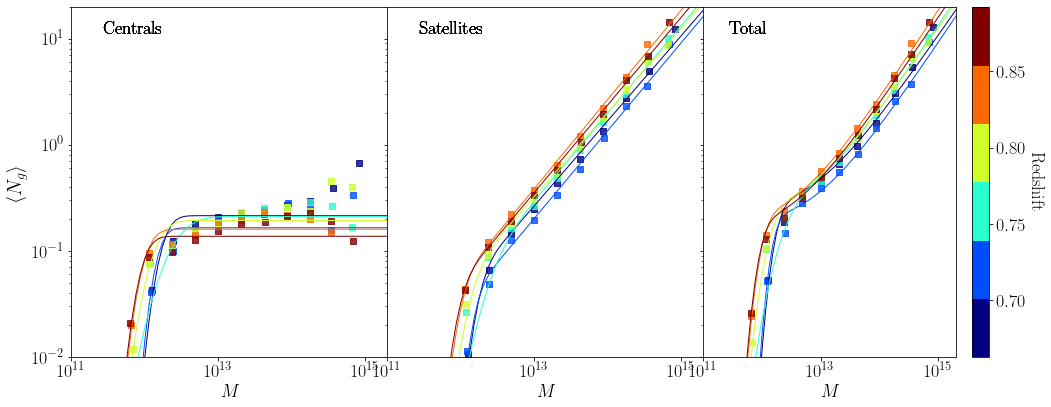

In [31]:
import matplotlib as mpl
zcen_array_all = 0.5*(np.array(out_dict['zmin_array']) + np.array(out_dict['zmax_array']))
jz_array_all = np.arange(len(zcen_array_all))

ind_0p6 = np.where(zcen_array_all > 0.65)[0]
jz_array_all = jz_array_all[ind_0p6]
zcen_array_all = zcen_array_all[ind_0p6]
jz_array = np.linspace(0,len(jz_array_all)-1,6).astype(int)
zcen_array = zcen_array_all[jz_array]

final_pos_mat = np.zeros((len(zcen_array),int(len(param_prior)/2)))

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
# colors = ['red','blue','orange','black','green','magenta']
cmap = plt.get_cmap('jet',len(zcen_array))
texts = ['Centrals','Satellites','Total']
M_arr = np.logspace(10,16,100)
for jz in range(len(zcen_array)):
    p0 = get_initial_state(nwalkers, param_prior)
    print(zcen_array[jz])
    M_cen = (out_dict['M_mean'][jz,:])
    n_cen = (out_dict['nc'][jz,:])
    M_sat = (out_dict['M_mean'][jz,:])
    n_sat = (out_dict['ns'][jz,:])
    ind_gtzero = np.where((M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0))[0]
    M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]

    x_cen = np.log10(M_cen)
    y_cen = np.log10(n_cen)
    x_sat = np.log10(M_sat)
    y_sat = np.log10(n_sat)
    hod_obs = np.hstack([n_cen,n_sat])
    sigma = 0.01*hod_obs
    cov_obs = np.diag(sigma**2)
    inv_cov_obs = np.linalg.inv(cov_obs)
    sampler = get_sampler(nwalkers, param_prior,x_cen, hod_obs, inv_cov_obs)
    final_pos, final_pos_sigma, sampler = get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='most_like')  
    final_pos_mat[jz,:] = final_pos
    
    th_dv = get_Nc_Ns_theory(np.log10(M_arr),final_pos)


    color =cmap(jz)
    for j in range(3):
        if j== 0:
            ax[j].plot(M_cen, n_cen,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color)  
            ax[j].errorbar(M_arr, th_dv[:100],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 1:
            ax[j].plot(M_cen, n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
            ax[j].errorbar(M_arr, th_dv[100:],ls='-',marker='',linewidth=1.0,color=color)   
        if j== 2:
            ax[j].plot(M_cen, n_cen + n_sat,ls='',marker='s',linewidth=3.0,alpha=0.8, color=color, mec=color) 
            ax[j].errorbar(M_arr, th_dv[:100] + th_dv[100:],ls='-',marker='',linewidth=1.0,color=color)   
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        ax[j].set_xlabel(r'$M$', size = 18)
        ax[j].set_ylim(1e-2,2e1)
        ax[j].set_xlim(1e11,2e15)
        ax[j].tick_params(axis='both', which='major', labelsize=18)
        ax[j].tick_params(axis='both', which='minor', labelsize=18)
    #     ax[j].legend(fontsize = 18, frameon = False)
        text = texts[j]
        ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


norm = mpl.colors.Normalize(vmin=np.amin(zcen_array),vmax=np.amax(zcen_array))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()
fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_fit_HOD_diffz_redmagic_hlum.pdf')




In [ ]:

fig, ax = plt.subplots(5,1, figsize = (6,19),sharex=True,sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
labels = [r'$\log{M_{\rm min}}$',r'$\sigma_{\log{M}}$',r'$f^{c}_{\rm max}$',r'$\log{M_1}$',r'$\alpha_p$']
for j in range(5):
    ax[j].plot(zcen_array, final_pos_mat[:,j],ls='-',marker='s',linewidth=3.0,color='red')  
#     ax[j].plot(M_mean[j,:], ns_pl[j,:],ls='-',marker='.',linewidth=2.0,color=colors[j])
    # ax.errorbar(M_block,fv_cl,ls='--',marker='',elinewidth=2.0,color='red',label='Cl')

#     ax[j].set_xscale('log')
#     ax[j].set_yscale('log')
    ax[j].set_ylabel(labels[j], size = 18)
#     ax[j].grid(True)
#     ax[j].set_ylim(1e-4,5e1)
#     ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
ax[-1].set_xlabel(r'$z$', size = 18)
plt.tight_layout()
fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/bestfit_params_evolve_redmagic.pdf')







In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

zmin_cut = zmin_array
N = len(zmin_cut)
cmap = plt.get_cmap('jet',N)

texts = ['Centrals','Satellites','Total']

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
for j in range(3):
    k = 0
    for jz in range(len(zmin_array)):
        if (zmin_array[jz] > np.amin(zmin_cut)) and (zmin_array[jz] < np.amax(zmin_cut)):
            color =cmap(k)
            if j== 0:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 1:
                ax[j].plot(M_mean[jz,:], ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 2:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:] + ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)    
            k += 1

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
#     ax[j].grid(True)
    ax[j].set_ylim(1e-4,1e2)
    ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
    text = texts[j]
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


norm = mpl.colors.Normalize(vmin=np.amin(zmin_cut),vmax=np.amax(zmin_cut))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

# fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_maglim_hod_evolve_highz.pdf')


    
    

In [146]:
M_arr = np.logspace(10,16,100)
th_dv = get_Nc_Ns_theory(np.log10(M_arr),final_pos)



No handles with labels found to put in legend.


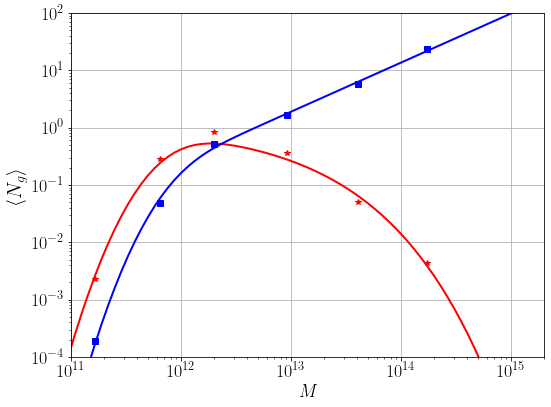

In [147]:


f1 = 10**(f_cen(np.log10(M_arr),12.5,0.5,0.5))
f2 = 10**(f_cen_exp(np.log10(M_arr),12.0,0.5,10.0,n=10))

fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']

ax.errorbar(M_cen, n_cen,ls='',marker='*',linewidth=2.0,color=colors[0])   
ax.errorbar(M_arr, th_dv[:100],ls='-',marker='',linewidth=2.0,color=colors[0])   
ax.errorbar(M_cen, n_sat,ls='',marker='s',linewidth=2.0,color=colors[1])   
ax.errorbar(M_arr, th_dv[100:],ls='-',marker='',linewidth=2.0,color=colors[1])   

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.set_ylim(1e-4,1e2)
ax.set_xlim(1e11,2e15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()











In [5]:

df = np.loadtxt('/global/cfs/cdirs/des/shivamp/HOD/chains/HODnew/bin13_3x2/Output/out_.txt')

df_w = df[:,0]

df_Mmin, df_M1, df_siglgM, df_al, df_fcen = df[:,2], df[:,3], df[:,4], df[:,5], df[:,6]

ind_range = np.arange(len(df_w))




In [11]:
(df_w/np.sum(df_w))



array([1.06080610e-70, 5.46665249e-62, 1.72264355e-61, ...,
       1.01927533e-03, 1.05288385e-03, 1.11613080e-03])

In [31]:

df_ll = df[:,1]
ind_min = np.where(df_ll == np.amin(df_ll))[0]
print(ind_min)
print(df_ll[ind_min])

ind_min_array = np.argsort(df_ll)[:30]
df_ll_min = df_ll[ind_min_array]


[1366]
[6.17908766]


In [32]:
M_arr = np.logspace(10,16,100)



IndexError: list index out of range

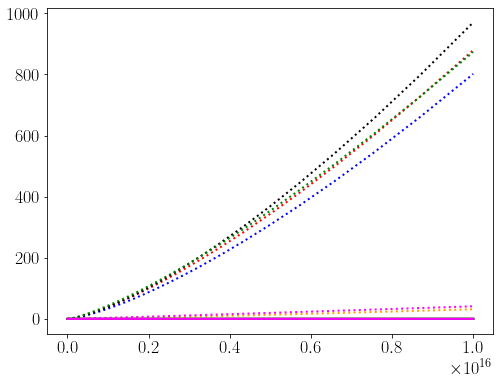

In [33]:


f1 = 10**(f_cen(np.log10(M_arr),12.5,0.5,0.5))
f2 = 10**(f_cen_exp(np.log10(M_arr),12.0,0.5,10.0,n=10))

fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']

# ax.errorbar(M_cen, n_cen,ls='',marker='*',linewidth=2.0,color=colors[0])  
for j in range(len(ind_min_array)):
    ind_min = ind_min_array[j]
    fcen_df = 10**(f_cen(np.log10(M_arr),df_Mmin[ind_min],df_siglgM[ind_min],df_fcen[ind_min]))
    fsat_df = 10**(f_sat(np.log10(M_arr),df_Mmin[ind_min],df_siglgM[ind_min],df_fcen[ind_min],df_M1[ind_min],df_al[ind_min]))
    ax.errorbar(M_arr, fcen_df,ls='-',marker='',linewidth=2.0,color=colors[j])   
    ax.errorbar(M_arr, fsat_df,ls=':',marker='',linewidth=2.0,color=colors[j])   
# ax.errorbar(M_cen, n_sat,ls='',marker='s',linewidth=2.0,color=colors[1])   
# ax.errorbar(M_arr, th_dv[100:],ls='-',marker='',linewidth=2.0,color=colors[1])   

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.set_ylim(1e-4,1e2)
ax.set_xlim(1e11,2e15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()












/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


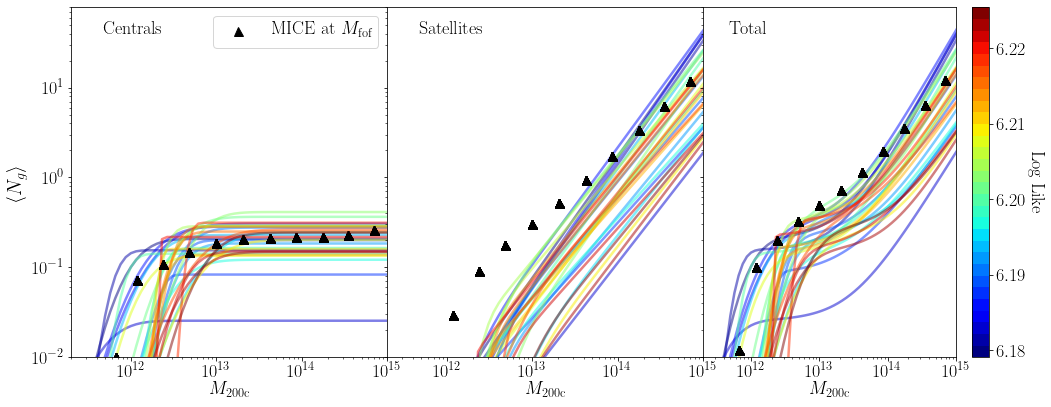

In [42]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure.pk'
cat_type = 'redmagic'
out_dict = dill.load(open(savefname,'rb'))
M_cen = (out_dict['M_mean'][0,:])
n_cen = (out_dict['nc'][0,:])
M_sat = (out_dict['M_mean'][0,:])
n_sat = (out_dict['ns'][0,:])
ind_gtzero = np.where( (M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0)  )[0]
M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]


N = len(ind_min_array)
cmap = plt.get_cmap('jet',N)

texts = ['Centrals','Satellites','Total']

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
for j in range(3):
    k = 0

    
    for jz in range(len(ind_min_array)):
        ind_min = ind_min_array[jz]
        fcen_df = 10**(f_cen(np.log10(M_arr),df_Mmin[ind_min],df_siglgM[ind_min],df_fcen[ind_min]))
        fsat_df = 10**(f_sat(np.log10(M_arr),df_Mmin[ind_min],df_siglgM[ind_min],df_fcen[ind_min],df_M1[ind_min],df_al[ind_min]))

        color =cmap(k)
        if j== 0:
            ax[j].plot(M_arr, fcen_df,ls='-',marker='',linewidth=2.5,alpha=0.5, color=color, mec=color)  
            if jz == 0:
                ax[j].plot(M_cen, n_cen,ls='',marker='^', color='k', ms=9,label=r'MICE at $M_{\rm fof}$')  
            else:
                ax[j].plot(M_cen, n_cen,ls='',marker='^', color='k', ms=9)  
        if j== 1:
            ax[j].plot(M_arr, fsat_df,ls='-',marker='',linewidth=2.5,alpha=0.5, color=color, mec=color)  
            ax[j].plot(M_cen, n_sat,ls='',marker='^', color='k', ms=9) 
        if j== 2:
            ax[j].plot(M_arr, fcen_df + fsat_df,ls='-',marker='',linewidth=2.5,alpha=0.5, color=color, mec=color)
            ax[j].plot(M_cen, n_cen + n_sat,ls='',marker='^', color='k', ms=9) 
        k += 1

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M_{\rm 200c}$', size = 18)
#     ax[j].grid(True)
    ax[j].set_ylim(1e-2,8e1)
    ax[j].set_xlim(2e11,1e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
    
    text = texts[j]
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    

ax[0].legend(fontsize = 18)
norm = mpl.colors.Normalize(vmin=np.amin(df_ll_min),vmax=np.amax(df_ll_min))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Log Like', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_redmagic_datafits_bin1_gammatonly.pdf') 


    
    